# Andel af Hospitaliseringer (non age corrected)

Find en forskydning mellem hospitaliseringer og antal positive på en dag, ved at analysere peaket omkring jul. Antal dage imellem peaket svarer altså til det antal dage der går fra du konstanteres smittes til en andel indlægges. Andelen findes til sidst ved antal hospitaliseringer (for forskydningen af dage frem) divideret med antal positive for dagen. Antallet af positive som bliver indlagt forventes umiddelbart at være konstant, dog er vi begyndt at vaccinere så langsomt bør vi kunne begynde at se andelen blive mindre.

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import numpy as np
import scipy 
import scipy.stats
from scipy import stats
import iminuit
from iminuit import Minuit

In [2]:
mpl.rcParams['font.size'] = 18      # Set the general plotting font size
plt.rc("font", family="serif")

# Indlæs data

In [32]:
folder = 'Data-Epidemiologiske-Rapport-12032021-uh7y'

data_hospital = pd.read_csv(folder + "/Newly_admitted_over_time.csv", sep=';', thousands='.', index_col=0)
data_posi = pd.read_csv(folder + "/Municipality_cases_time_series.csv", sep=';', thousands='.', index_col=0)

fit_to_latest = True

# Print how much data is included:
date_start = "2020-11-01"
if fit_to_latest :
    date_end = data_hospital.index[-3]  # Omitting the very latest data point (with ~0 statistics)
else :
    date_end = "2021-03-16"          # Value in latest report files
print("  Data used: ", date_start, "-", date_end)    


# All hospitalisations
H_all = data_hospital.loc[date_start:date_end]['Total']
eH_all = np.sqrt(H_all)

# Number of positives
P_all = data_posi.loc[date_start:date_end].sum(axis=1)
eP_all = np.sqrt(P_all)

# Array with times
Plot_startday = 0
Plot_endday = len(H_all)
days = np.arange(Plot_startday, Plot_endday)

  Data used:  2020-11-01 - 2021-03-09


# Plot hospitaliseringer og positive test, og sammenlign peaks

Text(0, 0.5, 'Antal positive')

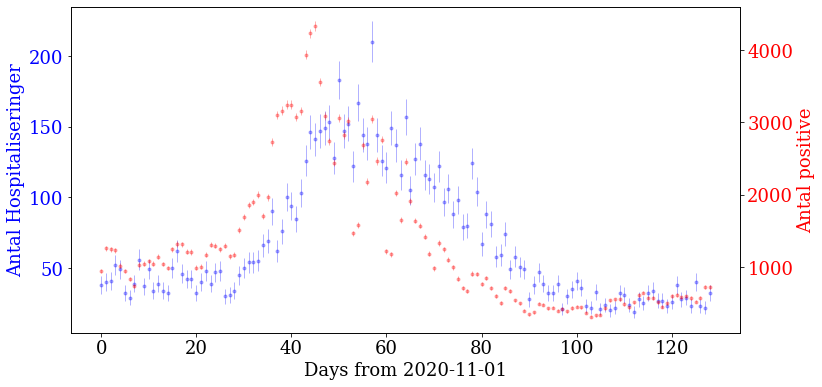

In [33]:
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.errorbar(days, H_all, yerr=eH_all, fmt='.', linewidth=1, label='Antal hospitaliseringer', color='blue', alpha=0.3)
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx() 
ax2.errorbar(days, P_all, yerr=eP_all, fmt='.', linewidth=1, label='Antal positive', color='red', alpha=0.3)
ax2.tick_params(axis='y', labelcolor='red')

ax1.set_xlabel(f'Days from {date_start}')
ax1.set_ylabel('Antal Hospitaliseringer', color='blue')
ax2.set_ylabel('Antal positive', color='red')

In [34]:
# Fit med en gauss på en lineær baggrund?

# Definer fit funktion
def gauss_plus_lin(x, N, mu, sigma, a, b):
    
    gauss = N * stats.norm.pdf(x, mu, sigma)
    
    lin = a*x + b
    
    return gauss + lin

# Definer chi2 udreging
def chi2_H(N, mu, sigma, a, b):
    
    y_fit = gauss_plus_lin(days, N, mu, sigma, a, b)
    chi2 = np.sum( ((H_all - y_fit) / eH_all)**2 )

    return chi2

def chi2_P(N, mu, sigma, a, b):
    
    y_fit = gauss_plus_lin(days, N, mu, sigma, a, b)
    chi2 = np.sum( ((P_all - y_fit) / eP_all)**2 )

    return chi2

# Fit the hospitalisations
minuit_H = Minuit(chi2_H, N=np.sum(H_all), mu=60, sigma=15, a=-2, b=50, print_level=1, errordef=1.0)
minuit_H.migrad(); 

# Fit the positives
minuit_P = Minuit(chi2_P, N=np.sum(P_all), mu=45, sigma=5, a=-2, b=70, print_level=1, errordef=1.0)
minuit_P.migrad(); 

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 286.5                      │        Nfcn = 676 (676 total)        │
│ EDM = 5.9e-05 (Goal: 0.0002)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 8671                       │        Nfcn = 190 (190 total)        │
│ EDM = 1.79e-06 (Goal: 0.0002)    │                                      │
├───────────

Text(0, 0.5, 'Antal positive')

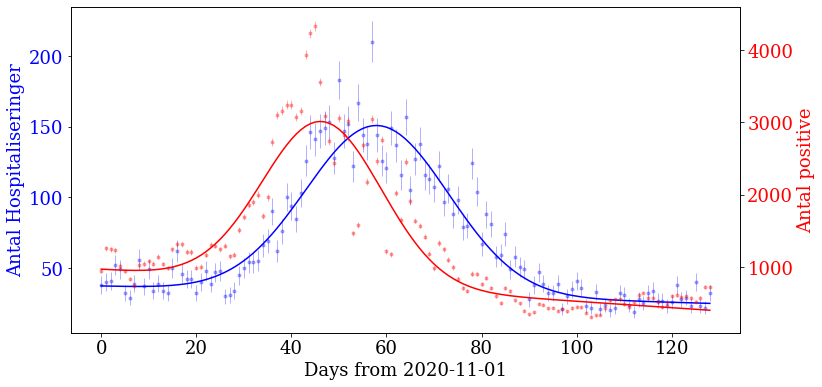

In [35]:
fig, ax1 = plt.subplots(figsize=(12,6))

# Hospitalisations plot
ax1.errorbar(days, H_all, yerr=eH_all, fmt='.', linewidth=1, label='Antal hospitaliseringer', color='blue', alpha=0.3)
ax1.tick_params(axis='y', labelcolor='blue')

# Hospitalisations fit
ax1.plot(days, gauss_plus_lin(days, *minuit_H.args), color='blue')

# Positives plot
ax2 = ax1.twinx() 
ax2.errorbar(days, P_all, yerr=eP_all, fmt='.', linewidth=1, label='Antal positive', color='red', alpha=0.3)
ax2.tick_params(axis='y', labelcolor='red')

# Positives fit
ax2.plot(days, gauss_plus_lin(days, *minuit_P.args), color='red')

ax1.set_xlabel(f'Days from {date_start}')
ax1.set_ylabel('Antal Hospitaliseringer', color='blue')
ax2.set_ylabel('Antal positive', color='red')

In [36]:
# What is the shift between the two peaks
shift = minuit_H.values['mu'] - minuit_P.values['mu']
eshift = minuit_H.errors['mu'] + minuit_P.errors['mu']
print(f'{ shift } +/- {eshift}' )

11.648637948018177 +/- 0.42000780468805676


# Andel af Hospitaliseringer pr dag. (med forskydning)

antal indlagte / antal positibe per dag, vi skal nok have forskydningen med. denne ratio skal være nogenlunde konstant men dalende pga vaccinationer.

Text(0, 0.5, 'Fraction of hospitalisations. \n H(12 days ahead)/P(now)')

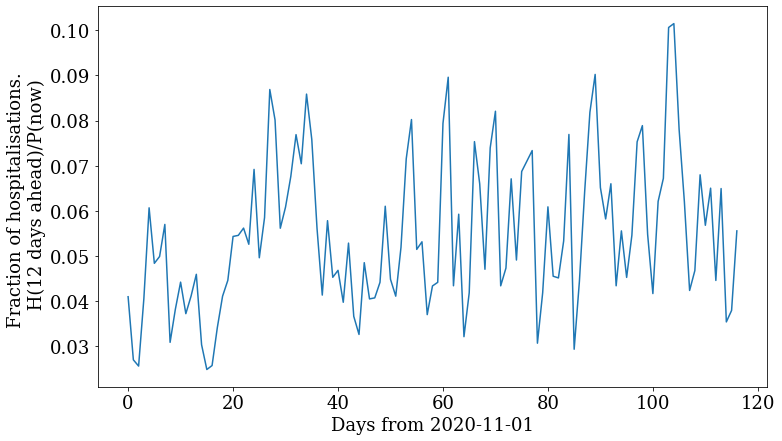

In [44]:
fig, ax = plt.subplots(figsize=(12,7))

ax.plot( days[:-12], [i/j for i,j in zip(H_all[12:], P_all[:-12]) ] )

ax.set_xlabel(f'Days from {date_start}')
ax.set_ylabel('Fraction of hospitalisations. \n H(12 days ahead)/P(now)')

Perhaps we should do this with the scaled positives instead?